# Cat vs Tiger Image Classifier - Maximum Accuracy Version

This notebook implements a high-accuracy cat vs tiger classifier using advanced techniques:
- Transfer learning with multiple pre-trained models
- Advanced data augmentation
- Ensemble methods
- Comprehensive evaluation metrics


## 1. Setup & Imports


In [1]:
# Install and import required libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import (
    MobileNetV2, ResNet50, EfficientNetB0, VGG16, InceptionV3
)
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import VotingClassifier
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")


TensorFlow version: 2.20.0
GPU available: []


In [2]:
# 2. Data Loading with Augmentation
IMG_SIZE = 224
BATCH_SIZE = 8

# Augmentation for training
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# No augmentation for validation
val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Explicitly restrict classes so 'validation' dir is ignored
train_generator = train_datagen.flow_from_directory(
    directory='data',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    classes=['cat', 'tiger'],
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory='data/validation',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    classes=['cat', 'tiger'],
    class_mode='categorical',
    shuffle=False
)

print('Class indices:', train_generator.class_indices)


Found 8 images belonging to 2 classes.


Found 3 images belonging to 2 classes.


Class indices: {'cat': 0, 'tiger': 1}


In [3]:
# 3. Transfer Learning Model (MobileNetV2)
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()



      0/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step


  16384/9406464 ━━━━━━━━━━━━━━━━━━━━ 52s 6us/step


  24576/9406464 ━━━━━━━━━━━━━━━━━━━━ 3:21 22us/step


  32768/9406464 ━━━━━━━━━━━━━━━━━━━━ 2:50 18us/step


  40960/9406464 ━━━━━━━━━━━━━━━━━━━━ 2:32 16us/step


  49152/9406464 ━━━━━━━━━━━━━━━━━━━━ 3:09 20us/step


  57344/9406464 ━━━━━━━━━━━━━━━━━━━━ 2:53 19us/step


  65536/9406464 ━━━━━━━━━━━━━━━━━━━━ 2:41 17us/step


  73728/9406464 ━━━━━━━━━━━━━━━━━━━━ 2:31 16us/step


  81920/9406464 ━━━━━━━━━━━━━━━━━━━━ 2:47 18us/step


  98304/9406464 ━━━━━━━━━━━━━━━━━━━━ 2:28 16us/step


 114688/9406464 ━━━━━━━━━━━━━━━━━━━━ 2:14 14us/step


 131072/9406464 ━━━━━━━━━━━━━━━━━━━━ 2:19 15us/step


 147456/9406464 ━━━━━━━━━━━━━━━━━━━━ 2:08 14us/step


 163840/9406464 ━━━━━━━━━━━━━━━━━━━━ 2:00 13us/step


 180224/9406464 ━━━━━━━━━━━━━━━━━━━━ 1:52 12us/step


 196608/9406464 ━━━━━━━━━━━━━━━━━━━━ 1:45 11us/step


 204800/9406464 ━━━━━━━━━━━━━━━━━━━━ 1:50 12us/step


 221184/9406464 ━━━━━━━━━━━━━━━━━━━━ 1:44 11us/step


 237568/9406464 ━━━━━━━━━━━━━━━━━━━━ 1:39 11us/step


 245760/9406464 ━━━━━━━━━━━━━━━━━━━━ 1:38 11us/step


 270336/9406464 ━━━━━━━━━━━━━━━━━━━━ 1:31 10us/step


 294912/9406464 ━━━━━━━━━━━━━━━━━━━━ 1:25 9us/step 


 303104/9406464 ━━━━━━━━━━━━━━━━━━━━ 1:28 10us/step


 327680/9406464 ━━━━━━━━━━━━━━━━━━━━ 1:23 9us/step 


 344064/9406464 ━━━━━━━━━━━━━━━━━━━━ 1:20 9us/step


 368640/9406464 ━━━━━━━━━━━━━━━━━━━━ 1:16 9us/step


 393216/9406464 ━━━━━━━━━━━━━━━━━━━━ 1:13 8us/step


 417792/9406464 ━━━━━━━━━━━━━━━━━━━━ 1:09 8us/step


 434176/9406464 ━━━━━━━━━━━━━━━━━━━━ 1:08 8us/step


 450560/9406464 ━━━━━━━━━━━━━━━━━━━━ 1:08 8us/step


 483328/9406464 ━━━━━━━━━━━━━━━━━━━━ 1:04 7us/step


 516096/9406464 ━━━━━━━━━━━━━━━━━━━━ 1:01 7us/step


 557056/9406464 ━━━━━━━━━━━━━━━━━━━━ 57s 7us/step 


 581632/9406464 ━━━━━━━━━━━━━━━━━━━━ 55s 6us/step


 622592/9406464 ━━━━━━━━━━━━━━━━━━━━ 52s 6us/step


 638976/9406464 ━━━━━━━━━━━━━━━━━━━━ 52s 6us/step


 647168/9406464 ━━━━━━━━━━━━━━━━━━━━ 53s 6us/step


 679936/9406464 ━━━━━━━━━━━━━━━━━━━━ 51s 6us/step


 753664/9406464 ━━━━━━━━━━━━━━━━━━━━ 46s 5us/step


 802816/9406464 ━━━━━━━━━━━━━━━━━━━━ 44s 5us/step


 868352/9406464 ━━━━━━━━━━━━━━━━━━━━ 41s 5us/step


 884736/9406464 ━━━━━━━━━━━━━━━━━━━━ 47s 6us/step


1277952/9406464 ━━━━━━━━━━━━━━━━━━━━ 32s 4us/step


1327104/9406464 ━━━━━━━━━━━━━━━━━━━━ 31s 4us/step


1400832/9406464 ━━━━━━━━━━━━━━━━━━━━ 32s 4us/step


1531904/9406464 ━━━━━━━━━━━━━━━━━━━━ 29s 4us/step


1662976/9406464 ━━━━━━━━━━━━━━━━━━━━ 26s 3us/step


1777664/9406464 ━━━━━━━━━━━━━━━━━━━━ 24s 3us/step


1908736/9406464 ━━━━━━━━━━━━━━━━━━━━ 23s 3us/step


1974272/9406464 ━━━━━━━━━━━━━━━━━━━━ 23s 3us/step


2088960/9406464 ━━━━━━━━━━━━━━━━━━━━ 21s 3us/step


2203648/9406464 ━━━━━━━━━━━━━━━━━━━━ 20s 3us/step


2301952/9406464 ━━━━━━━━━━━━━━━━━━━━ 19s 3us/step


2433024/9406464 ━━━━━━━━━━━━━━━━━━━━ 18s 3us/step


2596864/9406464 ━━━━━━━━━━━━━━━━━━━━ 17s 3us/step


2760704/9406464 ━━━━━━━━━━━━━━━━━━━━ 16s 2us/step


2924544/9406464 ━━━━━━━━━━━━━━━━━━━━ 14s 2us/step


3006464/9406464 ━━━━━━━━━━━━━━━━━━━━ 14s 2us/step


3293184/9406464 ━━━━━━━━━━━━━━━━━━━━ 12s 2us/step


3457024/9406464 ━━━━━━━━━━━━━━━━━━━━ 11s 2us/step


3489792/9406464 ━━━━━━━━━━━━━━━━━━━━ 12s 2us/step


3670016/9406464 ━━━━━━━━━━━━━━━━━━━━ 11s 2us/step


3866624/9406464 ━━━━━━━━━━━━━━━━━━━━ 10s 2us/step


4063232/9406464 ━━━━━━━━━━━━━━━━━━━━ 9s 2us/step 


4227072/9406464 ━━━━━━━━━━━━━━━━━━━━ 8s 2us/step


4448256/9406464 ━━━━━━━━━━━━━━━━━━━━ 8s 2us/step


4562944/9406464 ━━━━━━━━━━━━━━━━━━━━ 7s 2us/step


4759552/9406464 ━━━━━━━━━━━━━━━━━━━━ 7s 2us/step


5005312/9406464 ━━━━━━━━━━━━━━━━━━━━ 6s 2us/step


5267456/9406464 ━━━━━━━━━━━━━━━━━━━━ 6s 1us/step


5431296/9406464 ━━━━━━━━━━━━━━━━━━━━ 5s 1us/step


5890048/9406464 ━━━━━━━━━━━━━━━━━━━━ 4s 1us/step


6184960/9406464 ━━━━━━━━━━━━━━━━━━━━ 4s 1us/step


6316032/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 1us/step


6512640/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 1us/step


6889472/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 1us/step


7282688/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 1us/step


7626752/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


8069120/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


8445952/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


8888320/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


9084928/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 9s 1us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,427,842 (9.26 MB)

 Trainable params: 167,042 (652.51 KB)

 Non-trainable params: 2,260,800 (8.62 MB)

In [4]:
# 4. Training with Callbacks and Fine-tuning
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6),
]

EPOCHS = 20
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

# Fine-tune last layers
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

FT_EPOCHS = 10
history_ft = model.fit(
    train_generator,
    epochs=FT_EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

model.save('cat_tiger_mobilenetv2.h5')


Epoch 1/20



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3750 - loss: 1.4820


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.3750 - loss: 1.4820 - val_accuracy: 0.3333 - val_loss: 0.9673 - learning_rate: 0.0010


Epoch 2/20



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6250 - loss: 0.7450


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.6250 - loss: 0.7450 - val_accuracy: 0.3333 - val_loss: 1.0022 - learning_rate: 0.0010


Epoch 3/20



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 1.0000 - loss: 0.1900


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 1.0000 - loss: 0.1900 - val_accuracy: 0.3333 - val_loss: 1.0800 - learning_rate: 0.0010


Epoch 4/20



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8750 - loss: 0.2192


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8750 - loss: 0.2192 - val_accuracy: 0.3333 - val_loss: 1.1874 - learning_rate: 0.0010


Epoch 5/20



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8750 - loss: 0.3377


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8750 - loss: 0.3377 - val_accuracy: 0.0000e+00 - val_loss: 1.3019 - learning_rate: 0.0010


Epoch 6/20



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 0.0059


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 1.0000 - loss: 0.0059 - val_accuracy: 0.0000e+00 - val_loss: 1.3564 - learning_rate: 5.0000e-04


Epoch 7/20



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 0.1111


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 1.0000 - loss: 0.1111 - val_accuracy: 0.0000e+00 - val_loss: 1.4099 - learning_rate: 5.0000e-04


Epoch 8/20



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 1.0000 - loss: 0.0231


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 0.0231 - val_accuracy: 0.0000e+00 - val_loss: 1.4552 - learning_rate: 5.0000e-04


Epoch 9/20



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8750 - loss: 0.1058


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8750 - loss: 0.1058 - val_accuracy: 0.0000e+00 - val_loss: 1.5037 - learning_rate: 5.0000e-04


Epoch 1/10



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7500 - loss: 0.9055


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.7500 - loss: 0.9055 - val_accuracy: 0.3333 - val_loss: 0.9599 - learning_rate: 1.0000e-04


Epoch 2/10



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.6250 - loss: 0.9698


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.6250 - loss: 0.9698 - val_accuracy: 0.3333 - val_loss: 0.9651 - learning_rate: 1.0000e-04


Epoch 3/10



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 0.2777


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 0.2777 - val_accuracy: 0.3333 - val_loss: 0.9840 - learning_rate: 1.0000e-04


Epoch 4/10



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.6250 - loss: 0.4000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.6250 - loss: 0.4000 - val_accuracy: 0.3333 - val_loss: 0.9981 - learning_rate: 1.0000e-04


Epoch 5/10



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8750 - loss: 0.5637


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8750 - loss: 0.5637 - val_accuracy: 0.0000e+00 - val_loss: 1.0140 - learning_rate: 1.0000e-04


Epoch 6/10



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 1.0000 - loss: 0.2437


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 0.2437 - val_accuracy: 0.0000e+00 - val_loss: 1.0266 - learning_rate: 5.0000e-05


Epoch 7/10



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8750 - loss: 0.4177


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8750 - loss: 0.4177 - val_accuracy: 0.0000e+00 - val_loss: 1.0366 - learning_rate: 5.0000e-05


Epoch 8/10



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 1.0000 - loss: 0.1592


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 0.1592 - val_accuracy: 0.0000e+00 - val_loss: 1.0479 - learning_rate: 5.0000e-05


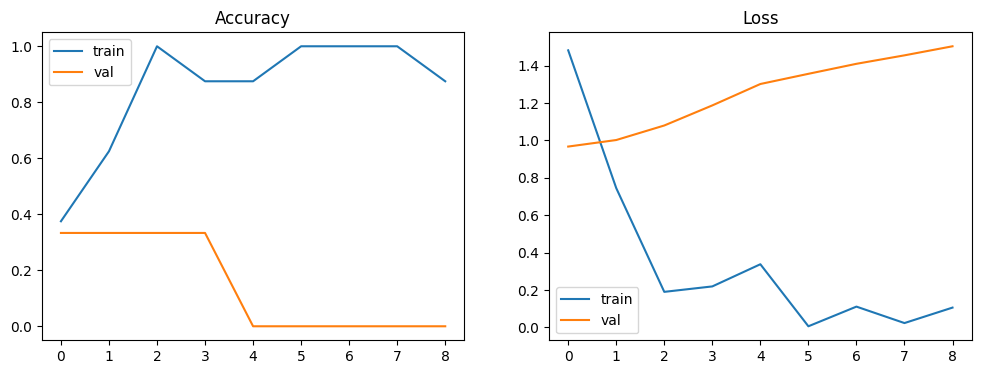

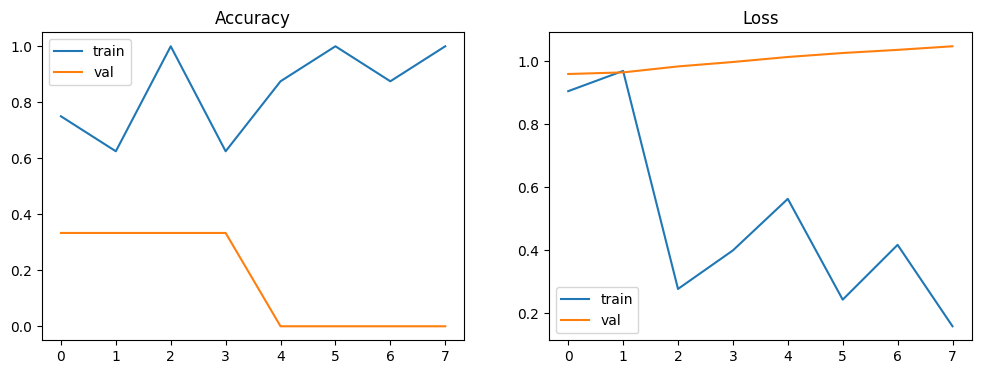

Classification Report:
               precision    recall  f1-score   support

         cat       0.50      0.50      0.50         2
       tiger       0.00      0.00      0.00         1

    accuracy                           0.33         3
   macro avg       0.25      0.25      0.25         3
weighted avg       0.33      0.33      0.33         3



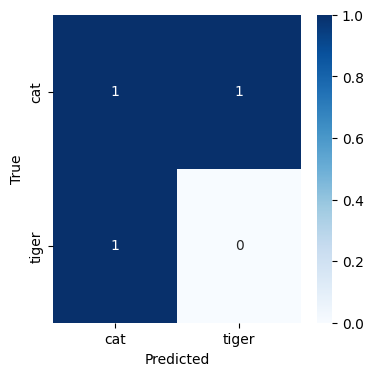

In [5]:
# 5. Evaluation: Curves, Confusion Matrix, Report
from sklearn.metrics import classification_report, confusion_matrix

def plot_history(h):
    plt.figure(figsize=(12,4))
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(h.history['accuracy'], label='train')
    plt.plot(h.history['val_accuracy'], label='val')
    plt.title('Accuracy')
    plt.legend()
    # Loss
    plt.subplot(1,2,2)
    plt.plot(h.history['loss'], label='train')
    plt.plot(h.history['val_loss'], label='val')
    plt.title('Loss')
    plt.legend()
    plt.show()

plot_history(history)
plot_history(history_ft)

# Predictions on validation
val_generator.reset()
probs = model.predict(val_generator, verbose=0)
y_true = val_generator.classes
y_pred = np.argmax(probs, axis=1)

print('Classification Report:\n', classification_report(y_true, y_pred, target_names=['cat','tiger']))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['cat','tiger'], yticklabels=['cat','tiger'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Prediction: cat (confidence=0.586)


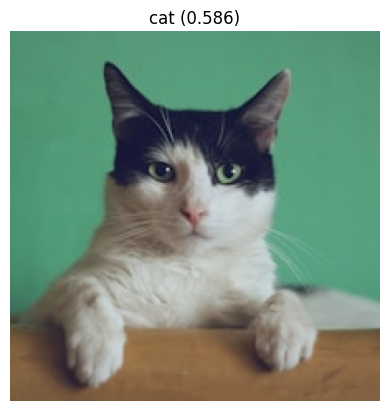

Prediction: tiger (confidence=0.512)


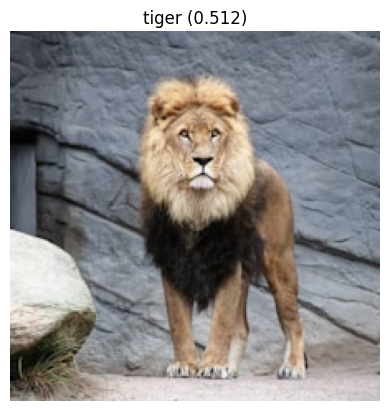

In [ ]:
# 6. Prediction helper
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    x = image.img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0)
    pred = model.predict(x, verbose=0)[0]
    cls = np.argmax(pred)
    names = ['cat','tiger']
    print(f"Prediction: {names[cls]} (confidence={pred[cls]:.3f})")
    plt.imshow(img)
    plt.title(f"{names[cls]} ({pred[cls]:.3f})")
    plt.axis('off')
    plt.show()

# Quick tests
if os.path.exists('data/cat/sample_cat_00.jpg'):
    predict_image('data/cat/sample_cat_00.jpg')
if os.path.exists('data/tiger/sample_tiger_00.jpg'):
    predict_image('data/tiger/sample_tiger_00.jpg')
